Task #1:
1. Train 4 different classifiers using sklearn library to predict "Activity" (biological response of the molecule) field from the "bioresponse.csv" dataset:
- small decision tree;
- deep decision tree;
- random forest on small trees;
- random forest on deep trees;
2. Calculate the following metrics to check the quality of your models:
- precision;
- recall;
- accuracy;
- F1-score;
- log-loss;
3. Plot precision-recall and ROC curves for your models.
4. Train a classifier who avoids Type II (False Negative) errors and calculate metrics  from p.2 for it.


# Import packages

In [97]:
from collections import defaultdict
import os
import os.path as osp

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
random_state = 100

# Load data

In [99]:
df = pd.read_csv("bioresponse.csv")
print(f"Shape of the df: {df.shape}")

Shape of the df: (3751, 1777)


In [100]:
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


# Split dataset to train and test parts by train_test_split

In [101]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df["Activity"])

# Train models and compute predictions

In [102]:
model_types = {
    "small": {
        "max_depth": 5,
        "random_state": random_state
    },
    "deep": {
        "max_depth": 15,
        "random_state": random_state
    }
}

models = {}
predicted_probs = {}
model_names = []

for model_name, model_class in zip(("tree", "random forest"), (DecisionTreeClassifier, RandomForestClassifier)):
    for depth_name, param_dict in model_types.items():
        name = f"{model_name}_{depth_name}"
        clf = model_class(**param_dict)
        clf.fit(df_train.drop(columns="Activity"), df_train["Activity"])

        models[name] = clf
        predicted_probs[name] = clf.predict_proba(df_test.drop(columns="Activity"))[:, 1]
        model_names.append(name)

In [103]:
models

{'tree_small': DecisionTreeClassifier(max_depth=5, random_state=100),
 'tree_deep': DecisionTreeClassifier(max_depth=15, random_state=100),
 'random forest_small': RandomForestClassifier(max_depth=5, random_state=100),
 'random forest_deep': RandomForestClassifier(max_depth=15, random_state=100)}

In [104]:
original_activity_name = "original_activity"
predicted_probs[original_activity_name] = df_test["Activity"].values
df_predicted_probs = pd.DataFrame(predicted_probs)
print(f"predicted_probs shape is {df_predicted_probs.shape}")

predicted_probs shape is (751, 5)


In [105]:
df_predicted_probs.head()

,tree_small,tree_deep,random forest_small,random forest_deep,original_activity
0,0.122186,0.000000,0.485789,0.389808,0
1,0.122186,1.000000,0.435901,0.636419,1
2,0.122186,0.019718,0.371813,0.325103,1
3,0.122186,1.000000,0.395370,0.346761,0
4,0.877651,0.973913,0.830229,0.931089,1


# Compute metrics

# Metric table

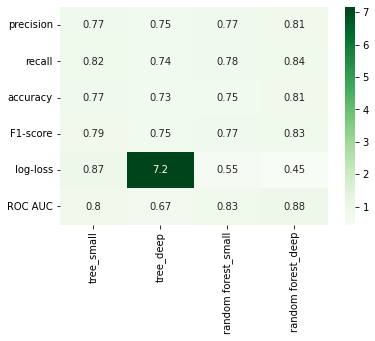

In [106]:
metrics_dict = defaultdict(dict)

threshold = 0.5

for name in model_names:
    # Form predicted class
    predicted_class = (df_predicted_probs[name] > threshold).astype(int)
    # Compute all metrics
    precision, recall, f_score, _ = metrics.precision_recall_fscore_support(df_predicted_probs[original_activity_name], predicted_class, average="binary")
    accuracy = metrics.accuracy_score(df_predicted_probs[original_activity_name], predicted_class)
    log_loss = metrics.log_loss(df_predicted_probs[original_activity_name], df_predicted_probs[name])
    roc_auc = metrics.roc_auc_score(df_predicted_probs[original_activity_name], df_predicted_probs[name])

    metric_name_value_pairs = zip(
        ("precision", "recall", "accuracy", "F1-score", "log-loss", "ROC AUC"),
        (precision, recall, accuracy, f_score, log_loss, roc_auc)
    )
    # Build metrics dict
    for metric_name, metric_value in metric_name_value_pairs:
        metrics_dict[name][metric_name] = metric_value

df_metrics = pd.DataFrame(metrics_dict)
sns.heatmap(df_metrics, cmap="Greens", annot=True);

tree_deep model overfitted and shows fewer metrics then tree_small model.
Also random_forest_deep works well and shows greater metrics then random_forest_small.


# Precision-recall and ROC AUC curves

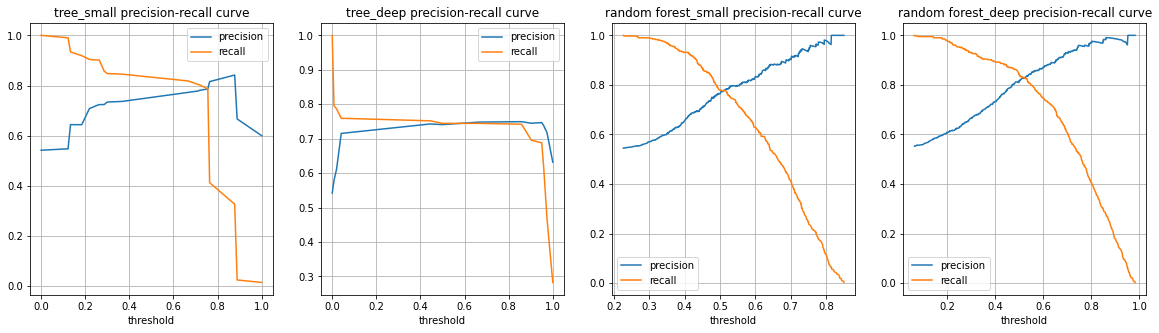

In [107]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

for id, name in enumerate(model_names):
    precision, recall, threshold = metrics.precision_recall_curve(df_predicted_probs[original_activity_name],  df_predicted_probs[name])
    axs[id].plot(threshold, precision[:-1], label="precision")
    axs[id].plot(threshold, recall[:-1], label="recall")
    axs[id].set_xlabel("threshold")
    axs[id].set_title(f"{name} precision-recall curve")
    axs[id].legend()
    axs[id].grid()

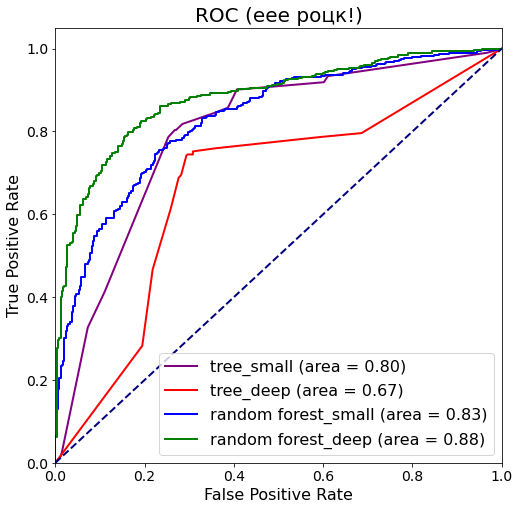

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))

for name, col in zip(model_names,("purple", "red", "blue", "green")):
    fpr, tpr, _ = metrics.roc_curve(df_predicted_probs[original_activity_name], df_predicted_probs[name])
    roc_auc = metrics.roc_auc_score(df_predicted_probs[original_activity_name], df_predicted_probs[name])
    plt.plot(fpr, tpr, color=col,
         lw=2, label=f"{name} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC (еее роцк!)", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# A model that avoids False Negative (FN)

The "class_weight" attribute has been added, for balances the class weights. As a result, recall reached its maximum.

In [109]:

forest_avoid_fn = RandomForestClassifier(max_depth=15, class_weight={0: 1, 1: 5}, random_state=random_state)
forest_avoid_fn = forest_avoid_fn.fit(df_train.drop(columns="Activity"), df_train["Activity"])
forest_avoid_fn_name = "forest_avoid_fn"
predicted_probs_avoid_fn = {}
predicted_probs_avoid_fn[forest_avoid_fn_name] = forest_avoid_fn.predict_proba(df_test.drop(columns="Activity"))[:, 1]
predicted_probs_avoid_fn[original_activity_name] = df_test["Activity"].values
df_predicted_probs_avoid_fn = pd.DataFrame(predicted_probs_avoid_fn)
df_predicted_probs_avoid_fn.head()

,forest_avoid_fn,original_activity
0,0.176564,0
1,0.803546,1
2,0.458203,1
3,0.427287,0
4,0.966572,1


In [110]:
predicted_avoid_fn_class = forest_avoid_fn.predict(df_test.drop(columns="Activity"))
print("precision = {precision:.3f}; recall = {recall:.3f}; accuracy = {accuracy:.3f}; f1 = {f1:.3f}; log_loss = {log_loss:.3f}".format(
    precision=metrics.precision_score(predicted_probs_avoid_fn[original_activity_name], predicted_avoid_fn_class),
    recall=metrics.recall_score(predicted_probs_avoid_fn[original_activity_name], predicted_avoid_fn_class),
    accuracy=metrics.accuracy_score(predicted_probs_avoid_fn[original_activity_name], predicted_avoid_fn_class),
    f1=metrics.f1_score(predicted_probs_avoid_fn[original_activity_name], predicted_avoid_fn_class),
    log_loss=metrics.log_loss(predicted_probs_avoid_fn[original_activity_name], predicted_avoid_fn_class))
)


precision = 0.720; recall = 0.909; accuracy = 0.759; f1 = 0.803; log_loss = 8.324


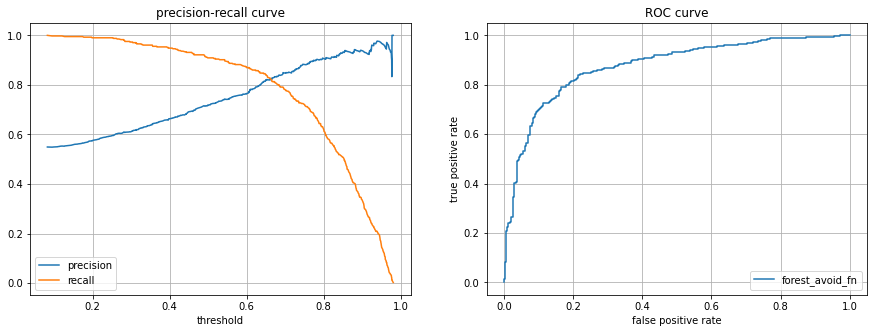

In [111]:
fig, (ax_pr, ax_roc) = plt.subplots(1, 2, figsize=(15, 5))

precision, recall, threshold = metrics.precision_recall_curve(df_predicted_probs_avoid_fn[original_activity_name],  df_predicted_probs_avoid_fn[forest_avoid_fn_name])
fpr, tpr, thr = metrics.roc_curve(df_predicted_probs_avoid_fn[original_activity_name],  df_predicted_probs_avoid_fn[forest_avoid_fn_name])

ax_pr.plot(threshold, precision[:-1], label="precision")
ax_pr.plot(threshold, recall[:-1], label="recall")
ax_pr.set_xlabel("threshold")
ax_pr.set_title("precision-recall curve")
ax_pr.legend()
ax_pr.grid()

plt.plot(fpr, tpr, label="forest_avoid_fn")
ax_roc.set_xlabel("false positive rate")
ax_roc.set_ylabel("true positive rate")
ax_roc.set_title("ROC curve")
ax_roc.legend(loc=4)
ax_roc.grid()